# Spark : Web Server Logs Analysis with Python

El análisis de registros del servidor es un caso de uso ideal para Spark. Es una fuente de datos común muy grande y contiene un rico conjunto de información. Spark le permite almacenar sus registros en archivos en disco de forma económica, al mismo tiempo que proporciona una forma rápida y sencilla de realizar análisis de datos en ellos. Esta tarea le mostrará cómo usar Apache Spark en registros de producción basados en texto del mundo real y aprovechar al máximo el poder de esos datos. Los datos de registro provienen de muchas fuentes, como servidores web, de archivos y de computación, registros de aplicaciones, contenido generado por el usuario, y se pueden usar para monitorear servidores, mejorar la inteligencia comercial y del cliente, crear sistemas de recomendación, detección de fraudes y mucho más.

#### Parte 1: Introducción y importación

Para este laboratorio, usaremos un conjunto de datos aleatorios del sitio web de Kaggle y contiene todas las solicitudes HTTP durante un año.


In [2]:
import findspark
findspark.init()

In [3]:
# Importamos librerias necesarias. 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import *

In [4]:
# Creamos las Session donde desarrollaremos nuestra aplicación.
spark = SparkSession.builder.appName("weblog").getOrCreate()

In [5]:
# Crearemos el esquema donde se alojaran los datos a importar. En nuestro caso obtendremos 4 campos:
schema = StructType([
StructField("ip",StringType(),False),
StructField("timestamp",StringType(),False),
StructField("value",StringType(),False),
StructField("status",StringType(),False)]
)

In [6]:
# Importamos los datos del csv
df_raw = spark.read.format("csv")\
.option("header","true")\
.option("inferSchema","false")\
.option("sep",",")\
.schema(schema)\
.load("data/weblog.csv")

AnalysisException: Path does not exist: file:/c:/Users/javier.gpenalosa/Github/Projects-1/Pyspark/#3WebLogs/data/weblog.csv;

In [24]:
# Comprobamos si se ha importado el archivo y damos un primer vistazo a nuestros datos.
df_raw.show(10, False)

+----------+---------------------+---------------------------------------------+------+
|ip        |timestamp            |value                                        |status|
+----------+---------------------+---------------------------------------------+------+
|10.128.2.1|[29/Nov/2017:06:58:55|GET /login.php HTTP/1.1                      |200   |
|10.128.2.1|[29/Nov/2017:06:59:02|POST /process.php HTTP/1.1                   |302   |
|10.128.2.1|[29/Nov/2017:06:59:03|GET /home.php HTTP/1.1                       |200   |
|10.131.2.1|[29/Nov/2017:06:59:04|GET /js/vendor/moment.min.js HTTP/1.1        |200   |
|10.130.2.1|[29/Nov/2017:06:59:06|GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1|200   |
|10.130.2.1|[29/Nov/2017:06:59:19|GET /profile.php?user=bala HTTP/1.1          |200   |
|10.128.2.1|[29/Nov/2017:06:59:19|GET /js/jquery.min.js HTTP/1.1               |200   |
|10.131.2.1|[29/Nov/2017:06:59:19|GET /js/chart.min.js HTTP/1.1                |200   |
|10.131.2.1|[29/Nov/2017:06:59:3

#### Part 2: Exploratory Data Analysis

Una vez importados los datos deberemos realizar un análisis exploratorio permitiéndonos hacernos una idea de la estructura de los datos y su composición.

In [25]:
print(f"Numero de registros weblogs: {df_raw.count()}")
df_raw.printSchema()

Numero de registros weblogs: 16007
root
 |-- ip: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- value: string (nullable = true)
 |-- status: string (nullable = true)



In [26]:
df_raw.describe().show()

+-------+----------+--------------------+-----------------+------------------+
|summary|        ip|           timestamp|            value|            status|
+-------+----------+--------------------+-----------------+------------------+
|  count|     16007|               16007|            16007|             16007|
|   mean|      null|                null|            992.0|230.19469250744189|
| stddev|      null|                null|343.2105767600993| 50.05853522906924|
|    min|10.128.2.1|C:WINDOWSSystem32...|           '*.o':|               200|
|    max|  timeout:|                 the|              not|             found|
+-------+----------+--------------------+-----------------+------------------+



In [27]:
df_raw.select([count(when(isnan(c), c)).alias(c) for c in df_raw.columns]).show()

+---+---------+-----+------+
| ip|timestamp|value|status|
+---+---------+-----+------+
|  0|        0|    0|     0|
+---+---------+-----+------+



#### 2.1 Exploración de variables

##### Variable IP

In [28]:
df_raw.groupby("ip").count().orderBy(desc("count")).show()

+----------+-----+
|        ip|count|
+----------+-----+
|10.128.2.1| 4257|
|10.131.0.1| 4198|
|10.130.2.1| 4056|
|10.129.2.1| 1652|
|10.131.2.1| 1626|
|    chmod:|   95|
|       rm:|   72|
|      [Tue|   17|
|       sh:|    7|
|      [Thu|    6|
|  timeout:|    5|
|      [Wed|    5|
|      [Mon|    5|
|    a.out:|    4|
|      [Fri|    1|
|      [Sat|    1|
+----------+-----+



Vemos que existen registros de ip extraños, deberemos estudiar esos registros por si podrían estar dañados o erróneos.

In [29]:
# Recogemos todos los datos donde la ip no coincide una estructura normal.
bad_lines = df_raw.filter(~col("ip").startswith("10"))

In [30]:
print(f"Numero de lineas malas:{bad_lines.count()}")
bad_lines.show()

Numero de lineas malas:218
+--------+---------+------------+------------+
|      ip|timestamp|       value|      status|
+--------+---------+------------+------------+
|  chmod:|   cannot|    'a.out':|          No|
|  chmod:|   cannot|'error.txt':|          No|
|     rm:|   cannot|      '*.o':|          No|
|     rm:|   cannot|    'a.out':|          No|
|  chmod:|   cannot|'error.txt':|          No|
|timeout:|      the|     command|      dumped|
|     sh:|     line|         451|Segmentation|
|     rm:|   cannot|      '*.o':|          No|
|  chmod:|   cannot|    'a.out':|          No|
|  chmod:|   cannot|'error.txt':|          No|
|     rm:|   cannot|      '*.o':|          No|
|  chmod:|   cannot|'error.txt':|          No|
|  chmod:|   cannot|'error.txt':|          No|
|  chmod:|   cannot|'error.txt':|          No|
|     rm:|   cannot|      '*.o':|          No|
|  chmod:|   cannot|'error.txt':|          No|
|  chmod:|   cannot|    'a.out':|          No|
|     rm:|   cannot|      '*.o':|

Observamos que se tratarían de registros erróneos que no nos aportara información a nuestro análisis. Entre estos registros vemos que hay muchos datos duplicados antes tomar una decisión sobre que hacer con los datos 
no aseguremos si existe información en estos registros eliminando los duplicados.


In [31]:
bad_lines.dropDuplicates().show(24)

+--------+--------------------+------------+------------+
|      ip|           timestamp|       value|      status|
+--------+--------------------+------------+------------+
|     sh:|                line|        1226|     Aborted|
|  a.out:|        main.cpp:51:|     main():|   Assertion|
|     rm:|              cannot|    'a.out':|          No|
|     sh:|C:WINDOWSSystem32...|         not|       found|
|     sh:|                line|         848|     Aborted|
|  chmod:|              cannot|'error.txt':|          No|
|    [Tue|                 Feb|     24:12.8|       2018]|
|     sh:|                line|         451|Segmentation|
|  chmod:|              cannot|    'a.out':|          No|
|    [Mon|                 Feb|     52:06.9|       2018]|
|    [Tue|                 Jan|     02:49.8|       2018]|
|timeout:|                 the|     command|      dumped|
|    [Wed|                 Dec|     29:09.2|       2017]|
|     sh:|                line|        1192|     Aborted|
|    [Thu|    

Existen 24 registros únicos que se repiten un total de 218 veces a lo largo de nuestro dataframe y no nos aportaría información lo que lo borraríamos para poder centrarnos en los weblog de nuestros clientes.

##### Variable Status

In [32]:
df_raw.groupby("status").count().show()

+------------+-----+
|      status|count|
+------------+-----+
|         200|11330|
|       2018]|   28|
|     Aborted|    4|
|   Assertion|    4|
|         206|   52|
|         302| 3498|
|         404|  251|
|       2017]|    7|
|      dumped|    5|
|          No|  167|
|         304|  658|
|       found|    2|
|Segmentation|    1|
+------------+-----+



Obtenemos cinco clases de status HTTP junto con 218 registros null.

#### Parte 3. Limpieza y Parseado de los datos 

Según los estudios anteriores que le hemos realizado a nuestro dataFrame nos hemos data cuenta que existen 218 registros erro neos que deberemos eliminar, ademas deberemos parsear nuestros datos para obtener mucho mas información de los mismo. La columna de Value debe dividirse en tres columnas mediante la función regex_extract permitendonos obtener el método, path y protocolo de la weblogs.

In [33]:
# Eliminamos todos lo registros erroneos
df_cleaned = df_raw.filter(col("ip").startswith("10"))

In [34]:
# Parseamos nuestros datos y realizamos un split para añadir mas columnas de nuestro interés al dataframe.
temp = df_cleaned.withColumn("ip",regexp_extract(col("ip"),r'(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})', 1))
temp=  temp.withColumn("timestamp",regexp_extract(col("timestamp"),r'\[(\d+\/\w{3}\/\d{4}:\d{2}:\d{2}:\d{2})', 1))
temp = temp.withColumn("metodo",regexp_extract(col("value"),r'(\w+)\s+([^\s]+)\s+(\w+\/\d+.\d+)', 1))
temp = temp.withColumn("path",regexp_extract(col("value"),r'(\w+)\s+([^\s]+)\s+(\w+\/\d+.\d+)', 2))
temp = temp.withColumn("protocolo",regexp_extract(col("value"),r'(\w+)\s+([^\s]+)\s+(\w+\/\d+.\d+)', 3))
temp = temp.withColumn("status",regexp_extract(col("status"),r'(\d{3})', 1))
temp = temp.drop("value")
df = temp.select("ip","timestamp","metodo","path","protocolo","status")
df.show(10)

[Row(ip='10.128.2.1', timestamp='29/Nov/2017:06:58:55', metodo='GET', path='/login.php', protocolo='HTTP/1.1', status='200'),
 Row(ip='10.128.2.1', timestamp='29/Nov/2017:06:59:02', metodo='POST', path='/process.php', protocolo='HTTP/1.1', status='302'),
 Row(ip='10.128.2.1', timestamp='29/Nov/2017:06:59:03', metodo='GET', path='/home.php', protocolo='HTTP/1.1', status='200'),
 Row(ip='10.131.2.1', timestamp='29/Nov/2017:06:59:04', metodo='GET', path='/js/vendor/moment.min.js', protocolo='HTTP/1.1', status='200'),
 Row(ip='10.130.2.1', timestamp='29/Nov/2017:06:59:06', metodo='GET', path='/bootstrap-3.3.7/js/bootstrap.js', protocolo='HTTP/1.1', status='200'),
 Row(ip='10.130.2.1', timestamp='29/Nov/2017:06:59:19', metodo='GET', path='/profile.php?user=bala', protocolo='HTTP/1.1', status='200'),
 Row(ip='10.128.2.1', timestamp='29/Nov/2017:06:59:19', metodo='GET', path='/js/jquery.min.js', protocolo='HTTP/1.1', status='200'),
 Row(ip='10.131.2.1', timestamp='29/Nov/2017:06:59:19', metod

In [35]:
# Parseamos la fecha
mes = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
def parse_clf_time(s):
    return "{0:02d}-{1:02d}-{2:04d} {3:02d}:{4:02d}:{5:02d}".format(
      int(s[7:11]),
      mes[s[3:6]],
      int(s[0:2]),
      int(s[12:14]),
      int(s[15:17]),
      int(s[18:20])
    )
u_parse_time = udf(parse_clf_time)
# Una vez parseada la fecha deberemos transformarla la tipología del dato y nos permita obtener mucha mas información de registro.
df = df.withColumn("timestamp",u_parse_time(df['timestamp']).cast('timestamp'))

In [1]:
df.cache()
df.show(10)

NameError: name 'df' is not defined

#### Parte 4. Analysis Walk-Through on the Web Server Log File

##### 1. ¿Analizá los status de los registros?

In [70]:
# Analizamos el status del http
df.groupby("status").count().orderBy("status").show()

+------+-----+
|status|count|
+------+-----+
|   200|11330|
|   206|   52|
|   302| 3498|
|   304|  658|
|   404|  251|
+------+-----+



Observamos que los principales status de los registros obtenidos se tratan de weblogs que se han realizado con éxito. Observamos que existen también weblogs que han salido defectuosos con el status 404, intentaremos analizar si existe una causa.

In [38]:
# Analizamos las conexiones por IP
df.where(col("status") == "404").groupby("ip").count().show()

+----------+-----+
|        ip|count|
+----------+-----+
|10.131.2.1|   30|
|10.128.2.1|   67|
|10.130.2.1|   52|
|10.131.0.1|   61|
|10.129.2.1|   41|
+----------+-----+



Observamos que hay una distribución uniforme por usuario entre los errores obtenidos en los registros.

In [39]:
# protocolos
df.where(col("status") == "404").groupby("protocolo").count().show()

+---------+-----+
|protocolo|count|
+---------+-----+
| HTTP/1.1|  251|
+---------+-----+



Los errores no se han producido por el uso de un protocolo desactualizado sino que se han producido todos ellos en la versión mas actualizada del dataframe. 

In [81]:
# Analizamos los caminos 
df.where(col("status") == "404").select(date_format("timestamp",'yyyy-MM-dd').alias("dia")).groupby(("dia")).count().orderBy(desc("count")).show(10)

+----------+-----+
|       dia|count|
+----------+-----+
|2017-12-21|   23|
|2017-11-14|   18|
|2017-11-11|   12|
|2017-11-30|   12|
|2017-11-09|   10|
|2017-11-13|   10|
|2017-11-16|   10|
|2017-11-08|    8|
|2017-11-15|    8|
|2017-12-20|    7|
+----------+-----+
only showing top 10 rows



In [75]:
df.where(col("status") == "404").groupby("path").count().orderBy(desc("count")).show(5,False)

+---------------------------------------+-----+
|path                                   |count|
+---------------------------------------+-----+
|/robots.txt                            |224  |
|/favicon.ico                           |19   |
|/djs/vendor/bootstrap-datetimepicker.js|7    |
|/css/bootstrap.min.css.map             |1    |
+---------------------------------------+-----+



Nos hemos encontrado que los errores en los registros se han obtenido al intentar acceder a cuatro direcciones.

##### 2. Principales Web donde se realizan los métodos POST y quien es el usuario que más usa este método

In [41]:
# Principales Web donde hacemos POST
df.where(col("metodo") == "POST").groupby("path").count().orderBy(desc("count")).show(10,False)

+----------------------+-----+
|path                  |count|
+----------------------+-----+
|/process.php          |313  |
|/compile.php          |96   |
|/action.php           |81   |
|/pcompile.php         |77   |
|/contestsubmission.php|47   |
|/allsubmission.php    |26   |
|/contestproblem.php   |11   |
|/update.php           |7    |
|/contest.php          |7    |
|/archive.php          |7    |
+----------------------+-----+
only showing top 10 rows



In [71]:
# Usuario que realizan mas POST
df.where(col("metodo") == "POST").groupby("ip").count().orderBy(desc("count")).first()

Row(ip='10.131.0.1', count=181)

##### 3. Cuales son las 3 direcciones mas utilizadas por cada usuario.

In [43]:
# PATH mas usadas por cada Usuario.
ranked =  df.select("ip","path").groupby("ip","path").count().withColumn("rank", dense_rank().over(Window.partitionBy("ip").orderBy(desc("count"))))


In [44]:
ranked.select("ip","path","count","rank").where(col("rank") < 4) .show(20,False)

+----------+---------------------------------------------------------------+-----+----+
|ip        |path                                                           |count|rank|
+----------+---------------------------------------------------------------+-----+----+
|10.131.2.1|/login.php                                                     |174  |1   |
|10.131.2.1|/                                                              |138  |2   |
|10.131.2.1|/contestproblem.php?name=RUET%20OJ%20Server%20Testing%20Contest|102  |3   |
|10.128.2.1|/login.php                                                     |995  |1   |
|10.128.2.1|/home.php                                                      |874  |2   |
|10.128.2.1|/js/vendor/modernizr-2.8.3.min.js                              |482  |3   |
|10.130.2.1|/login.php                                                     |963  |1   |
|10.130.2.1|/home.php                                                      |790  |2   |
|10.130.2.1|/js/vendor/modernizr

#### 4.¿Cuales es el horario más común que la gente entra a la web?

In [74]:
horas = df.groupby(hour("timestamp").alias("Hora")).count().orderBy("Hora").toPandas()
horas

,Hora,count
0,0,118
1,1,53
2,2,48
3,3,164
4,4,246
5,5,283
6,6,575
7,7,313
8,8,284
9,9,187


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

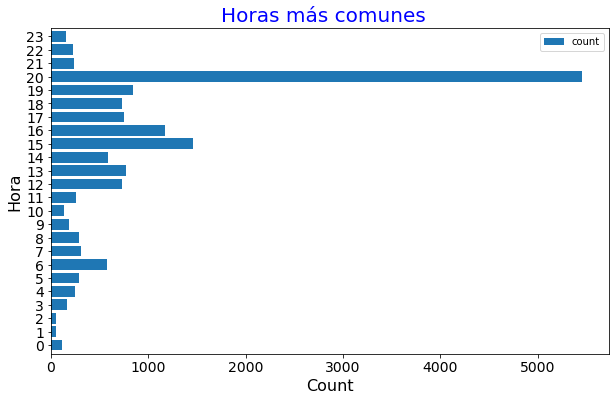

In [68]:
myplot= horas.plot(figsize=(10,6),kind="barh",width=0.8,x="Hora",y="count")
plt.xlabel("Count", fontsize = 16)
plt.ylabel("Hora", fontsize = 16)
plt.title("Horas más comunes  ", fontsize = 20, color = 'b')
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

Observamos que la hora más común que usa la gente para entrar son las 20:00 horas.